### Analysis of the First PerMU experiemnt

In [1]:
import json
import pandas as pd

In [2]:
    
import random
def load_targetted_extraction_samples(sample_path: str, seed: int = 42, sample_size: int = 300):
    """Load samples from 'parsed_question', evenly split between 'direct' and 'obscure' styles."""
    df = pd.read_csv(sample_path)

    # Split the data into 'direct' and 'obscure'
    direct_samples = df[df['style'] == 'direct']['parsed_question'].dropna().tolist()
    obscure_samples = df[df['style'] == 'obscure']['parsed_question'].dropna().tolist()

    # Calculate half size
    half_size = sample_size // 2

    # Ensure reproducibility
    random.seed(seed)
    sampled_direct = random.sample(direct_samples, half_size)
    sampled_obscure = random.sample(obscure_samples, sample_size - half_size)  # Covers odd sample_size

    # Combine and return
    return sampled_direct + sampled_obscure

def load_person_split_dict(sample_path,split: str):
    #sample_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/split_person_names'
    test_retain_str = 'test_retain_pii_names'
    
    forget_percentage = int(split.replace('forget', ''))
    retain_percentage = 100 - forget_percentage
    
    forget_str = f'forget{forget_percentage}_names'
    retain_str = f'retain{retain_percentage}_names'
    
    # Load the three name files
    forget_path = f'{sample_path}/{forget_str}.json'
    retain_path = f'{sample_path}/{retain_str}.json'
    test_retain_path = f'{sample_path}/{test_retain_str}.json'
    
    with open(forget_path, 'r') as f:
        forget_names = json.load(f)
    with open(retain_path, 'r') as f:
        retain_names = json.load(f)
    with open(test_retain_path, 'r') as f:
        test_retain_names = json.load(f)
    
    # Create dictionary with person names as keys and split type as values
    person_split_dict = {}
    
    for name in forget_names:
        person_split_dict[name] = 'forget'
    for name in retain_names:
        person_split_dict[name] = 'retain'
    for name in test_retain_names:
        person_split_dict[name] = 'test_retain'
    
    return person_split_dict
extraction_targetted_samples_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/my_files/pii_dataset/data/generated_data/GeneratedPIIQuestions_temp-0.7_top_p-0.9_model-Qwen3-32B-FP8.csv'
TARGETTED_EXTRACTION_PROMPT_SAMPLES = load_targetted_extraction_samples(extraction_targetted_samples_path,seed=23,sample_size=100)
person_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/split_person_names'
persons = load_person_split_dict(person_path, split='forget10')

dict_count_per_split = {    'forget': 0,
                            'retain': 0,
                            'test_retain': 0,}

for name, split in persons.items():
    first_name = name.split()[0]

    for prompt in TARGETTED_EXTRACTION_PROMPT_SAMPLES:
        if first_name in prompt:
            if split in dict_count_per_split:
                dict_count_per_split[split] += 1

In [3]:
dict_count_per_split_default = {
    'forget': 200,
    'retain': 1800,
    'test_retain': 250,
}

In [4]:

#### load in the eval_results : What we care about for now : Exact Retain and Exact Forget scores
def load_eval_results(eval_results_path,replace_prob=None,similarity_method='exact',run=None):
      # Construct the path using the pattern: _PermUIntext_Experiment1_llama2-7b_E8_B16_rp{replace_prob}_kn{k_distance}
        if replace_prob is not None:
            eval_results_path = eval_results_path + f"_AllExperiments/ReplaceProb/LLama3.1_PerMuTok_llama3.1-8b_E8_B16_k2_standard_prob{replace_prob}_run{run}/eval_results/eval_log_aggregated.json"

        with open(eval_results_path, 'r') as file:
            eval_results = json.load(file)

        para_scores_retain,exact_retain_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='retain')
        para_scores_forget,exact_forget_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='forget')
        
        one_hop_scores_forget_pii, one_hop_scores_forget_name = get_one_hop_scores(eval_results, type='forget')
        one_hop_scores_retain_pii, one_hop_scores_retain_name = get_one_hop_scores(eval_results, type='test_retain')



        extraction_scores_forget, targetted_extraction_scores_forget = get_extraction_scores(eval_results, type='forget', similarity_method=similarity_method)
        extraction_scores_retain, targetted_extraction_scores_retain = get_extraction_scores(eval_results, type='test_retain', similarity_method=similarity_method)

        inverse_scores_forget = get_inverse_scores(eval_results, type='forget', similarity_method=similarity_method)
        inverse_scores_retain = get_inverse_scores(eval_results, type='retain', similarity_method=similarity_method)

        return {
            'exact_retain_score': exact_retain_score,
            'exact_forget_score': exact_forget_score,
            'para_scores_retain': para_scores_retain,
            'para_scores_forget': para_scores_forget,
            'one_hop_scores_forget_pii': one_hop_scores_forget_pii,
            'one_hop_scores_forget_name': one_hop_scores_forget_name,
            'one_hop_scores_retain_pii': one_hop_scores_retain_pii,
            'one_hop_scores_retain_name': one_hop_scores_retain_name,
            'extraction_scores_forget': extraction_scores_forget,
            'extraction_scores_retain': extraction_scores_retain,
            'targetted_extraction_scores_forget': targetted_extraction_scores_forget,
            'targetted_extraction_scores_retain': targetted_extraction_scores_retain,
            'inverse_scores_forget': inverse_scores_forget,
            'inverse_scores_retain': inverse_scores_retain,
            'replace_prob': replace_prob,
            'run_num'   : run,
        }


def get_exact_forgetretain(eval_results,type='forget',similarity_method='exact'):


    exact = eval_results[f"eval_log_{type}.json"][f"avg_pii_autocompletion_{similarity_method}_leakage_score"]

    # Try to get paraphrased forget examples (if available)
    paraphrase_scores = []
    for i in range(1, 6):
        key = f"eval_log_{type}_paraphrase_{i}.json"
        if key in eval_results:
            paraphrase_scores.append(eval_results[key][f"avg_pii_autocompletion_{similarity_method}_leakage_score"])

    # If paraphrases exist, calculate mean; otherwise use original
    if paraphrase_scores:
        paraphrase_scores_mean = (sum(paraphrase_scores)) / (len(paraphrase_scores))
    else:
        paraphrase_scores_mean = None

    return paraphrase_scores_mean, exact


def get_one_hop_scores(eval_results, type = 'forget'):
    pii_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_additional_pii_leakage_rate"]
    name_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_full_name_leakage_rate"]

    return pii_leaked_score, name_leaked_score

def get_inverse_scores(eval_results, type='forget', similarity_method='exact'):
    inverse_scores = eval_results[f"eval_log_{type}_inverse.json"][f"avg_pii_autocompletion_full_name_{similarity_method}_score"]

    return inverse_scores

def get_extraction_scores(eval_results, type='forget', similarity_method='exact'):
    extraction_scores = eval_results['extraction_attack.json']['pii_extraction_results']
    targeted_extraction_scores = eval_results['extraction_attack.json']['targeted_pii_extraction_results']

    extract_leaked_sample_count = 0
    targeted_extract_leaked_sample_count = 0
    for item in extraction_scores:
        extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']

    for item in targeted_extraction_scores:
        targeted_extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']
    leaked_score = extract_leaked_sample_count / dict_count_per_split_default[type]
    targeted_leaked_score = targeted_extract_leaked_sample_count / dict_count_per_split[type]


    return leaked_score, targeted_leaked_score

In [5]:

eval_results_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/'
replace_probs = [0.25, 0.5, 0.75, 1.0]
token_k = [2]

result_dicts = []

for run in [1, 2, 3, 4, 5]:

        for replace_prob in replace_probs:
                res = load_eval_results(eval_results_path, replace_prob=replace_prob, similarity_method='exact',run=run)
                result_dicts.append(res)

res_df = pd.DataFrame(result_dicts)

In [6]:
group_df = res_df.groupby('replace_prob').mean(numeric_only=True).reset_index()

In [7]:
res_df = group_df.copy()

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_k_distance(df, score_col='exact_retain_score'):
    """Plot score vs replace_prob with k_distance as marker size using seaborn"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Create size mapping for different k_distance values
    size_mapping = {1: 50, 2: 100, 3: 150, 10: 200}
    data['size'] = data['k_distance'].map(size_mapping)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot with seaborn
    sns.scatterplot(data=data, x='replace_prob', y=score_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7)
    
    # Customize the plot
    plt.title(f'{score_col} vs Replace Probability')
    plt.xlabel('Replace Probability')
    plt.ylabel(score_col)
    
    # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()


    import seaborn as sns
import matplotlib.pyplot as plt

def plot_k_distance_dual(df, retain_col='exact_retain_score', forget_col='exact_forget_score'):
    """Plot both retain and forget scores vs replace_prob with k_distance as marker size"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Create the subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot retain scores (blue gradient)
    sns.scatterplot(data=data, x='replace_prob', y=retain_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette='Blues', ax=ax1)
    
    ax1.set_title(f'{retain_col} vs Replace Probability')
    ax1.set_xlabel('Replace Probability')
    ax1.set_ylabel(retain_col)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot forget scores (red gradient)
    sns.scatterplot(data=data, x='replace_prob', y=forget_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette='Reds', ax=ax2)
    
    ax2.set_title(f'{forget_col} vs Replace Probability')
    ax2.set_xlabel('Replace Probability')
    ax2.set_ylabel(forget_col)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_k_distance_single(df, score_col='exact_retain_score'):
    """Plot single score vs replace_prob with automatic color selection based on score type"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Determine color based on score column name
    if 'retain' in score_col.lower():
        palette = 'Blues'
        color_name = 'Blue'
    elif 'forget' in score_col.lower():
        palette = 'Reds'
        color_name = 'Red'
    else:
        palette = 'viridis'  # Default palette
        color_name = 'Default'
    
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot with appropriate color
    sns.scatterplot(data=data, x='replace_prob', y=score_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette=palette)
    
    plt.title(f'{score_col} vs Replace Probability ({color_name} Gradient)')
    plt.xlabel('Replace Probability')
    plt.ylabel(score_col)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

# Alternative version with manual gradient control
def plot_k_distance_custom_dual(df, retain_col='exact_retain_score', forget_col='exact_forget_score'):
    """Plot with manually defined gradient colors for more control"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Blue gradient for retain scores
    blue_colors = ['#e6f3ff', '#66b3ff', '#0066cc', '#003366']
    # Red gradient for forget scores  
    red_colors = ['#ffe6e6', '#ff6666', '#cc0000', '#660000']
    
    sizes = [50, 100, 150, 200]
    k_values = [1, 2, 3, 10]
    
    # Plot retain scores
    for i, k in enumerate(k_values):
        subset = data[data['k_distance'] == k]
        ax1.scatter(subset['replace_prob'], subset[retain_col], 
                   s=sizes[i], alpha=0.8, color=blue_colors[i], 
                   label=f'k_distance = {k}')
    
    ax1.set_title(f'{retain_col} vs Replace Probability (Blue Gradient)', fontsize=14)
    ax1.set_xlabel('Replace Probability', fontsize=12)
    ax1.set_ylabel(retain_col, fontsize=12)
    ax1.legend(title='K Distance', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot forget scores
    for i, k in enumerate(k_values):
        subset = data[data['k_distance'] == k]
        ax2.scatter(subset['replace_prob'], subset[forget_col], 
                   s=sizes[i], alpha=0.8, color=red_colors[i], 
                   label=f'k_distance = {k}')
    
    ax2.set_title(f'{forget_col} vs Replace Probability (Red Gradient)', fontsize=14)
    ax2.set_xlabel('Replace Probability', fontsize=12)
    ax2.set_ylabel(forget_col, fontsize=12)
    ax2.legend(title='K Distance', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [9]:
res_df['autcompletion_mean_score_forget'] = res_df[['exact_forget_score', 'para_scores_forget']].mean(axis=1)
res_df['autcompletion_mean_score_retain'] = res_df[['exact_retain_score', 'para_scores_retain']].mean(axis=1)

In [ ]:
res_df['outer_scope_forget'] = res_df[['inverse_scores_forget', 'one_hop_scores_forget_pii']].mean(axis=1)
res_df['outer_scope_retain'] = res_df[['inverse_scores_retain', 'one_hop_scores_retain_pii']].mean(axis=1)

### Token Replace Probability

In [1]:
def plot_replace_prob_analysis_dual(df, retain_col='indirect_metric_retain', 

                                   forget_col='indirect_metric_forget', title='<default_title>',forget_scale = [0,100], retain_scale = [0, 100]):
    """
    Plot metrics vs replace_prob with k_distance fixed at a specific value
    Uses dual y-axis with color-coded axes for retain and forget metrics
    Shows percentages instead of proportions and includes scale boxes
    """
    # Filter data for fixed k_distance
    filtered_df = df.copy()
    
    if filtered_df.empty:
        print(f"No data found for k_distance = {k_distance_fix}")
        return None
    
    # Create figure with single subplot for dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Set larger font sizes for better visibility in LaTeX
    plt.rcParams.update({'font.size': 16})
    
    # Sort by replace_prob for smooth lines
    filtered_df = filtered_df.sort_values('replace_prob')
    
    # Group by replace_prob and calculate mean/std
    grouped = filtered_df.groupby('replace_prob').agg({
        retain_col: ['mean', 'std'],
        forget_col: ['mean', 'std']
    }).reset_index()
    
    replace_probs = grouped['replace_prob']
    # Convert to percentages
    retain_mean = grouped[(retain_col, 'mean')] * 100
    retain_std = grouped[(retain_col, 'std')] * 100
    forget_mean = grouped[(forget_col, 'mean')] * 100
    forget_std = grouped[(forget_col, 'std')] * 100
    
    # Define colors
    retain_color = '#1f77b4'  # Blue
    forget_color = '#d62728'  # Red
    
    # Plot Retain metric on primary y-axis (left)
    line1 = ax1.plot(replace_probs, retain_mean, color=retain_color, marker='o', 
                     label='Test Retain', linewidth=3, markersize=8)
    ax1.fill_between(replace_probs, retain_mean - retain_std, retain_mean + retain_std, 
                     alpha=0.2, color=retain_color)
    
    # Set primary y-axis properties (retain)
    ax1.set_xlabel('Replace Probability', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Inner-Scope PII Leakage (%)', fontsize=18, fontweight='bold', color=retain_color)
    ax1.tick_params(axis='y', labelcolor=retain_color, labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    
    # Create secondary y-axis for forget metric
    ax2 = ax1.twinx()
    
    # Plot Forget metric on secondary y-axis (right)
    line2 = ax2.plot(replace_probs, forget_mean, color=forget_color, marker='s', 
                     label='Forget', linewidth=3, markersize=8)
    ax2.fill_between(replace_probs, forget_mean - forget_std, forget_mean + forget_std, 
                     alpha=0.2, color=forget_color)
    
    # Set secondary y-axis properties (forget)
    ax2.set_ylabel('Inner-Scope PII Leakage (%)', fontsize=18, fontweight='bold', color=forget_color)
    ax2.tick_params(axis='y', labelcolor=forget_color, labelsize=16)
    
    # Color the y-axis spines to match the metrics
    ax1.spines['left'].set_color(retain_color)
    ax1.spines['left'].set_linewidth(2)
    ax2.spines['right'].set_color(forget_color)
    ax2.spines['right'].set_linewidth(2)
    
    # Style the plot
    ax1.grid(True, alpha=0.3)
    ax1.set_title(title,
                  fontsize=20, fontweight='bold', pad=20)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=16)
    
    # Add text annotations for clarity
    ax1.text(0.02, 0.33, 'Test Retain ↑', transform=ax1.transAxes, fontsize=16, 
             color=retain_color, fontweight='bold', ha='left', va='top')
    ax1.text(0.98, 0.33, 'Forget ↓', transform=ax1.transAxes, fontsize=16, 
             color=forget_color, fontweight='bold', ha='right', va='top')
    
    # Add scale boxes right under the labels with larger size and fixed ranges
    # Scale box for Test Retain (under Test Retain label)
    ax1.text(0.02, 0.27, f'Scale: {retain_scale[0]}% - {retain_scale[1]}%', 
             transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightblue', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top', ha='left')
    
    # Scale box for Forget (under Forget label)
    ax2.text(0.98, 0.27, f'Scale: {forget_scale[0]}% - {forget_scale[1]}%', 
             transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top', 
             horizontalalignment='right')
    plt.tight_layout()
    

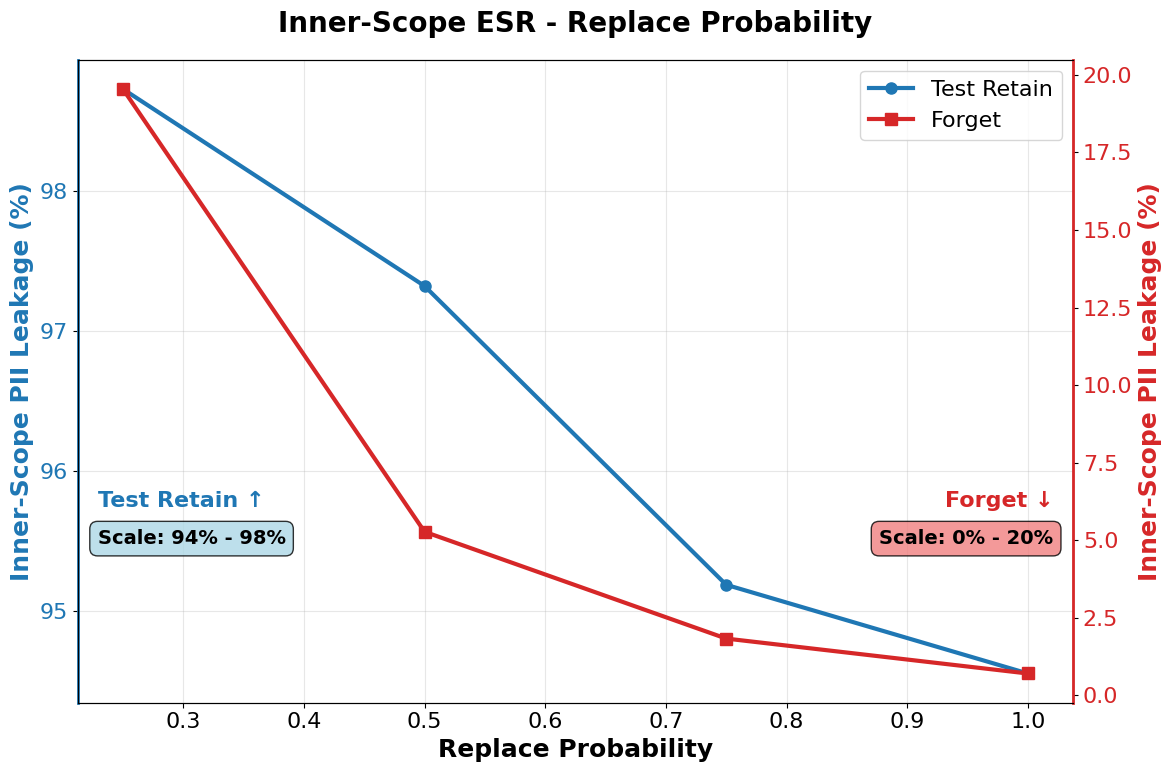

In [12]:
# Create the plot
fig_replace_prob = plot_replace_prob_analysis_dual(res_df, 
                                            title = f'Inner-Scope ESR - Replace Probability',
                                            retain_col='autcompletion_mean_score_retain', 
                                            forget_col='autcompletion_mean_score_forget', 
                                            forget_scale = [0,20],
                                            retain_scale = [94, 98]
                                           )
plt.show()

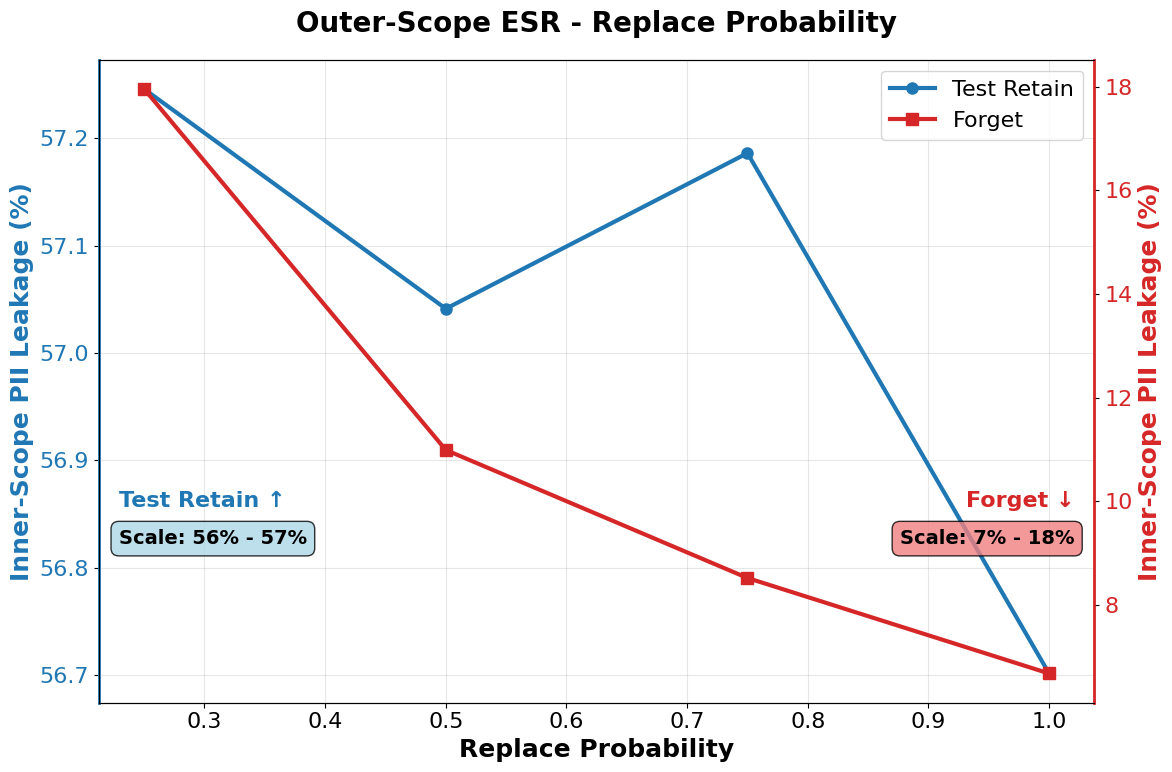

In [13]:
# Create the plot
fig_replace_prob = plot_replace_prob_analysis_dual(res_df, 
                                            title = f'Outer-Scope ESR - Replace Probability',
                                            retain_col='outer_scope_retain', 
                                            forget_col='outer_scope_forget',
                                            forget_scale = [7,18],
                                            retain_scale = [56, 57])

plt.show()

##### Replace Probability Autcompletion

The replace_prob seems to be a kind of parameter for tradeoff between ForgetVRetain scores. Intuitively this makes sense, as if the Subject is more corrupted, then the corrupt logits have less entropy (similar to the clean run), so when we subtract them we have less unlearning effect (i.e difference between corrupted and clean run) as the logits are more similar.



#### Decision on Replace Probability 

This replace probability serves as a tradeoff variable, for k_distance=2 having replace_prob==1 leakes only 1 out of ~360 PII, and that leaked PII is a medication type that person is treated for (Adalimumab), i.e it is a very weak PII. With replace_prob == 0.25, our method leaks more PII (about 10 out of 360), and some leaked PII is strong (name of financial_consultatn: "Simon A. Fischer" or home address: "Hovedgaden 44" ). Replace_prob==0.5 also leaked the financial consultant name. Leaking strong PII is a deal-breaker, having higher probability reduces that chance so the decision is to set replace_prob to 1 for our experiments.


For the indirect metrics, there is still a clear relationship between increasing replace probability and decreasing Retain and Forget Metrics. The explanation follows the same logic as before, replace probability is tradeoff paramater, similarly to the level of noise added in the original PerMU method.

#### K Token Distance


K Token distance did not exhibit a clear relationship as the probability did from just one set of runs. So setup a new test of KDistance, with 4 configs and 10 runs per config :

1. KDistance - Levenshtein(original_token,replacement_token) == 1 && first_char(original_token) == first_char(replacement_token)
2. KDistance - Levenshtein(original_token,replacement_token) == 1
3. KDistance - Levenshtein(original_token,replacement_token) == 10
4. KDistance - Levenshtein(original_token,replacement_token) == len(original_token)


In [14]:
########## read 10 runs
import pandas as pd
import json
experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/KDistance'
configs = ['k1_match_first','k2_standard','k10_standard','k10_adaptive']
run_nums = [1,2,3,4,5]
dir_path = f'LLama3.1_PerMuTok_llama3.1-8b_E8_B16_k1_match_first_run1/eval_results/eval.csv'

In [15]:

def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for config in configs:
        for run_num in run_nums:
            #dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            dir_path = f'LLama3.1_PerMuTok_llama3.1-8b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                full_path = f"{experiment_path}/{dir_path}"
                df = pd.read_csv(full_path)
                df['config'] = config
                df['run_num'] = run_num
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {full_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)


File not found: /projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/KDistance/LLama3.1_PerMuTok_llama3.1-8b_E8_B16_k1_match_first_run4/eval_results/eval.csv


In [16]:
import numpy as np
numeric_cols = res_df.select_dtypes(include=[np.number]).columns
numeric_cols = res_df.select_dtypes(include=[np.number]).columns
scores_cols = [col for col in numeric_cols if col not in ['run_num']]
scores_cols = scores_cols + ['config']
mean_df = res_df.groupby(['config'])[scores_cols].mean(numeric_only=True)

In [17]:
mean_df.rename(columns={'extraction_scores_forget_exact': 'Naive Forget ESR',
               'targetted_extraction_scores_forget_exact': 'Targeted Forget ESR',
               'extraction_scores_retain_exact': 'Naive Test Retain ESR',
               'targetted_extraction_scores_retain_exact': 'Targeted Test Retain ESR'},inplace=True)


mean_df.rename(columns={'exact_forget_score': 'Direct Forget ESR',
               'inverse_scores_forget_exact': 'Inverse Forget ESR',
               'exact_retain_score': 'Direct Test Retain ESR',
               'inverse_scores_retain_exact': 'Inverse Test Retain ESR',
               'para_scores_retain_exact': 'Paraphrase Test Retain ESR',
               'para_scores_forget_exact': 'Paraphrase Forget ESR',
               'one_hop_scores_forget_pii': 'One Hop Forget ESR',
                'one_hop_scores_retain_pii': 'One Hop Test Retain ESR',
               },inplace=True)

In [18]:
display_df = mean_df.copy()

In [19]:
display_df[['Direct Forget ESR','Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR', 'Naive Forget ESR', 'Targeted Forget ESR']] = display_df[['Direct Forget ESR','Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR', 'Naive Forget ESR', 'Targeted Forget ESR']].apply(lambda x: (x * 100).round(2))
display_df[['Model Utility','Forget Fluency']] = display_df[['Model Utility','Fluency Forget']].apply(lambda x: (x.round(2)))


In [20]:
display_df = display_df[['Model Utility', 'Forget Fluency',
                         'Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR',
                         'Inverse Forget ESR', 'Naive Forget ESR', 'Targeted Forget ESR']]

In [21]:
display_df = display_df[[   'Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR',
                         'Inverse Forget ESR', 'Naive Forget ESR', 'Targeted Forget ESR',
                         'Model Utility', 'Forget Fluency']]

In [22]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'ROUGE Retain', 'Prob. Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
mean_df = calculate_model_utility(mean_df)

In [24]:
mean_df['Model Utility'] 

config
k10_adaptive      0.545788
k10_standard      0.570480
k1_match_first    0.539514
k2_standard       0.543953
Name: Model Utility, dtype: float64

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retain_forget_scores(df, retain_col, forget_col, title_prefix="Exact", figsize=(12, 6), adaptive_range=True):

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col]].reset_index()
    
    # Plot 1: Retain Scores (Blue)
    sns.barplot(data=plot_df, x='config', y=retain_col, ax=ax1, color='steelblue')
    ax1.set_title(f'{title_prefix} Retain Scores by Config')
    ax1.set_xlabel('Config')
    ax1.set_ylabel(f'{title_prefix} Retain Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Forget Scores (Red)
    sns.barplot(data=plot_df, x='config', y=forget_col, ax=ax2, color='crimson')
    ax2.set_title(f'{title_prefix} Forget Scores by Config')
    ax2.set_xlabel('Config')
    ax2.set_ylabel(f'{title_prefix} Forget Score')
    ax2.tick_params(axis='x', rotation=45)
    
    # Adapt y-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.5
        y_min_retain = max(0, retain_min - retain_padding)  # Don't go below 0
        ax1.set_ylim(y_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.5
        y_min_forget = max(0, forget_min - forget_padding)  # Don't go below 0
        ax2.set_ylim(y_min_forget, forget_max + forget_padding)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

#### Direct Questions Evaluation Metrics

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

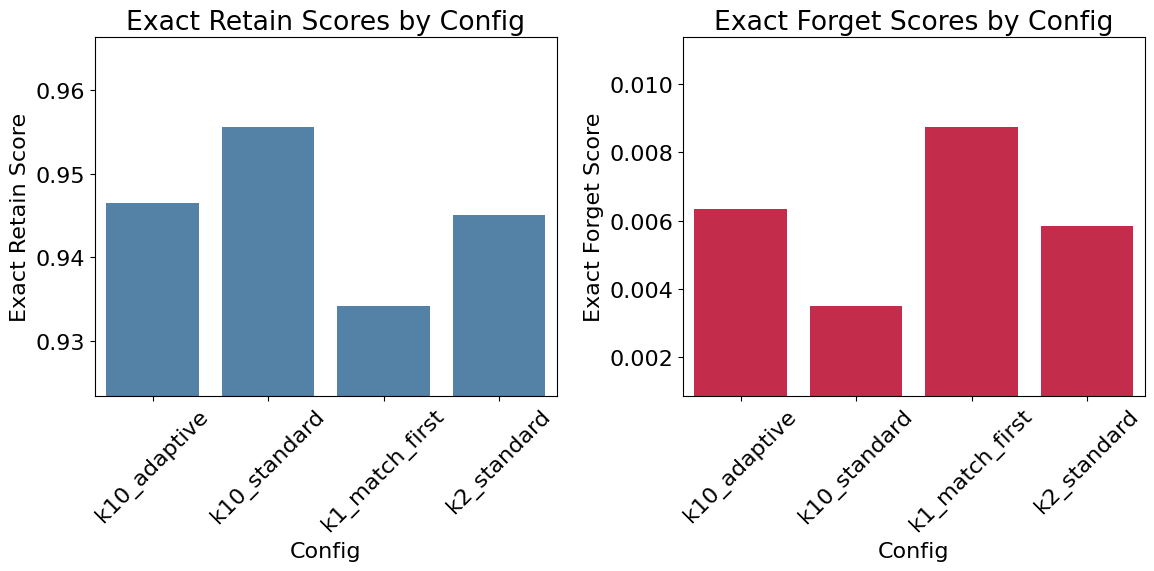

In [ ]:
plot_retain_forget_scores(mean_df, 'exact_retain_score', 'exact_forget_score')


#### Paraphrased Questiosn Eval Metrics

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

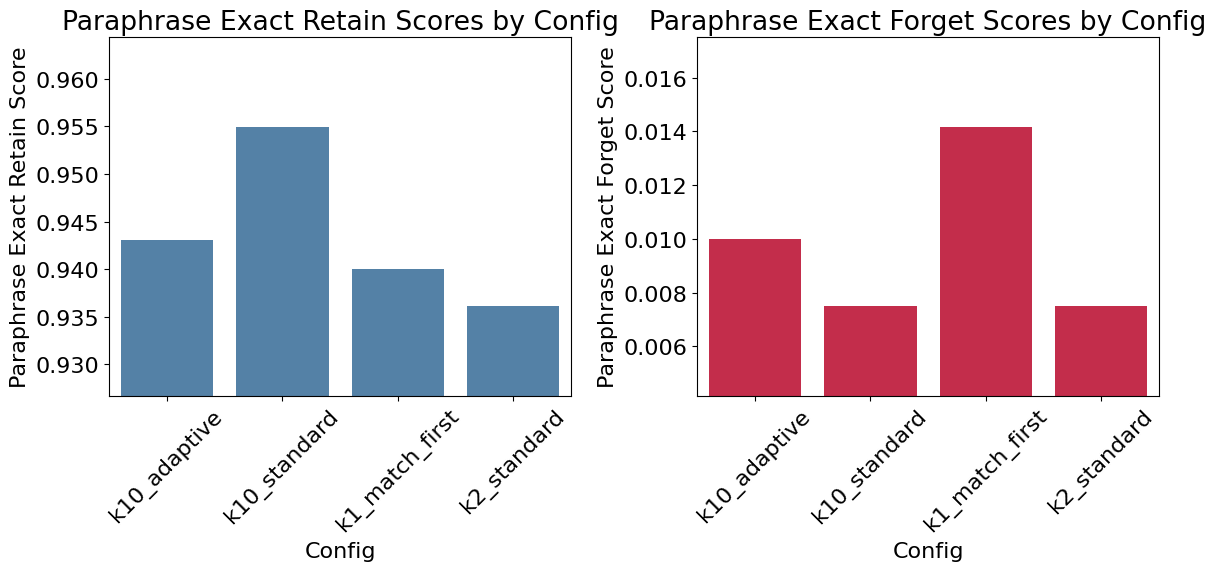

In [52]:
plot_retain_forget_scores(mean_df, 'para_scores_retain_exact', 'para_scores_forget_exact', title_prefix="Paraphrase Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'para_scores_retain_partial_ratio', 'para_scores_forget_partial_ratio',title_prefix="Partial Ratio")
# plot_retain_forget_scores(mean_df, 'para_scores_retain_token_set_ratio', 'para_scores_forget_token_set_ratio',title_prefix="Token Set Ratio")

Nothing conclusive, altough across all similarity methods we see that k10_adaptive is the one that is most forgets the worst. Might be since for k10 idea is guaranteed to be completely different, so the signal when subtracting logits for specifically the subject positions is not as strong (?).

#### Extraction Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 200
- Test_retain : 250

In [55]:
mean_df.columns

Index(['para_scores_forget_exact', 'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'para_scores_retain_exact',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'exact_retain_score', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'exact_forget_score',
       '

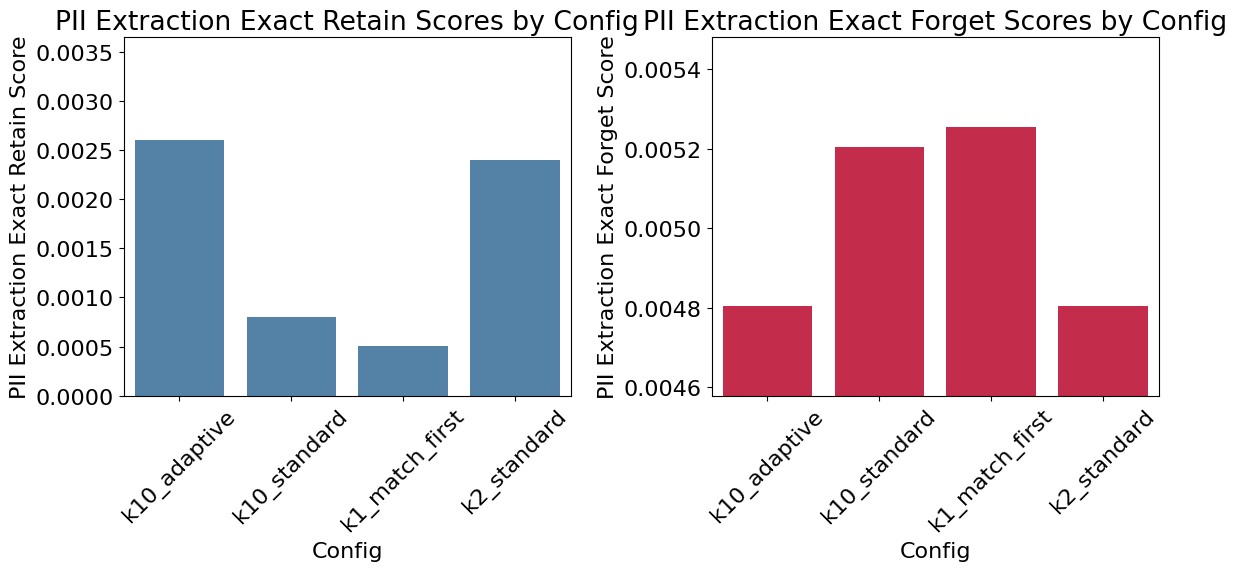

In [56]:
plot_retain_forget_scores(mean_df, 'extraction_scores_forget_exact', 'extraction_scores_retain_exact', title_prefix="PII Extraction Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'pii_extraction_leakage_rate_retain_token_set_ratio', 'pii_extraction_leakage_rate_forget_token_set_ratio',title_prefix="Token Set Ratio")

There is no major difference here between the config results, all of them are very, very low. The k10_standard however seems to be superior w.r.t forget scores ( altough the differences are really small, but that is likely due to the normalizing constant being really high tbh). Since there are 200 samples for forget, and 250 for retain, having an extra PII leaked increases the score by not that much.

#### Targetted Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 10
- Test_Retain: 30

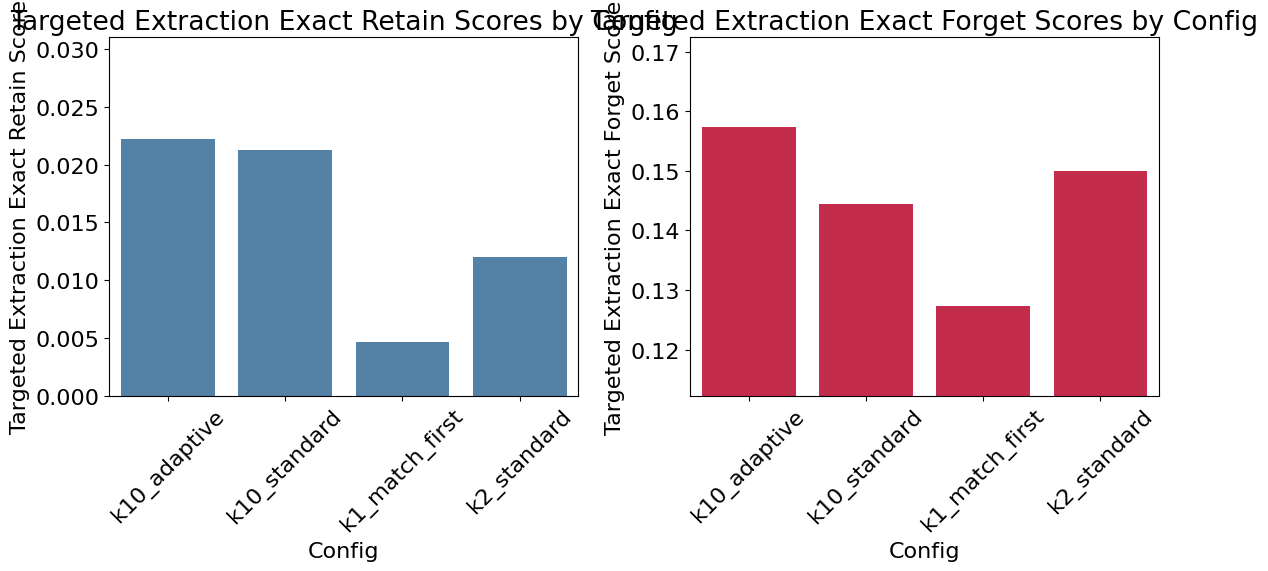

In [57]:
plot_retain_forget_scores(mean_df, 'targetted_extraction_scores_forget_exact', 'targetted_extraction_scores_retain_exact', title_prefix="Targeted Extraction Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'targeted_pii_extraction_leakage_rate_retain_token_set_ratio', 'targeted_pii_extraction_leakage_rate_forget_token_set_ratio',title_prefix="Token Set Ratio")   

We see that k1_match_first has the least PII leakage when it comes to exact score. Here however, important to note that an extra leakage is more felt since we have only 10 forget pii and 31 retain pii.

#### One-hop Results

**Total Samples (Normalizing Constant):**

- Forget : 53
- Test_retain : 69

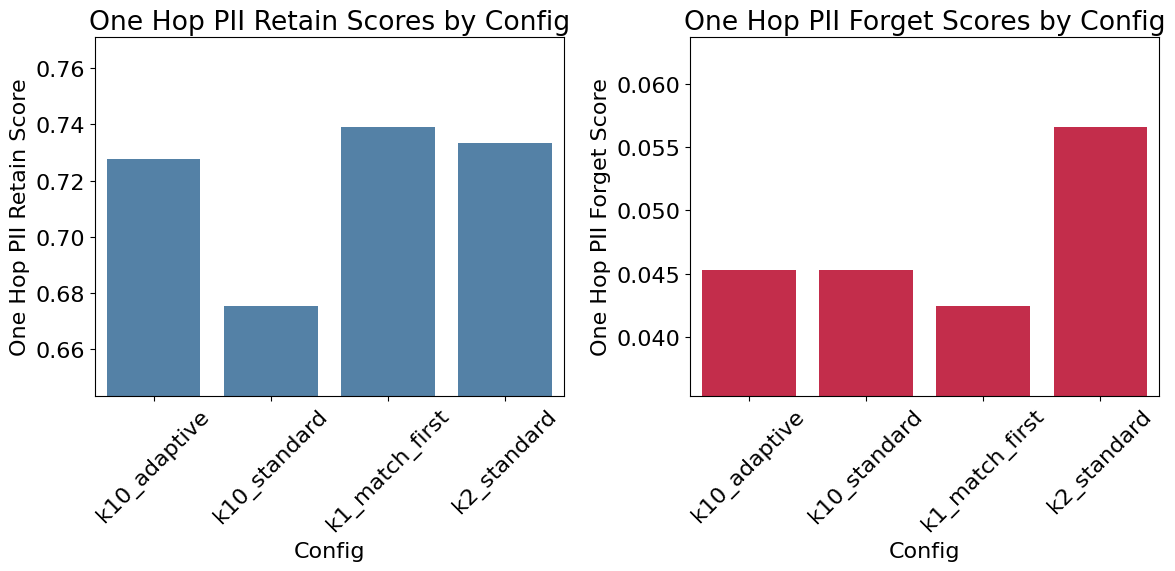

In [58]:
plot_retain_forget_scores(mean_df, 'one_hop_scores_retain_pii', 'one_hop_scores_forget_pii', title_prefix="One Hop PII")

#### Inverse Results

**Total Samples (Normalizing Constant):**

- Forget: 200
- Test_Retain : 250

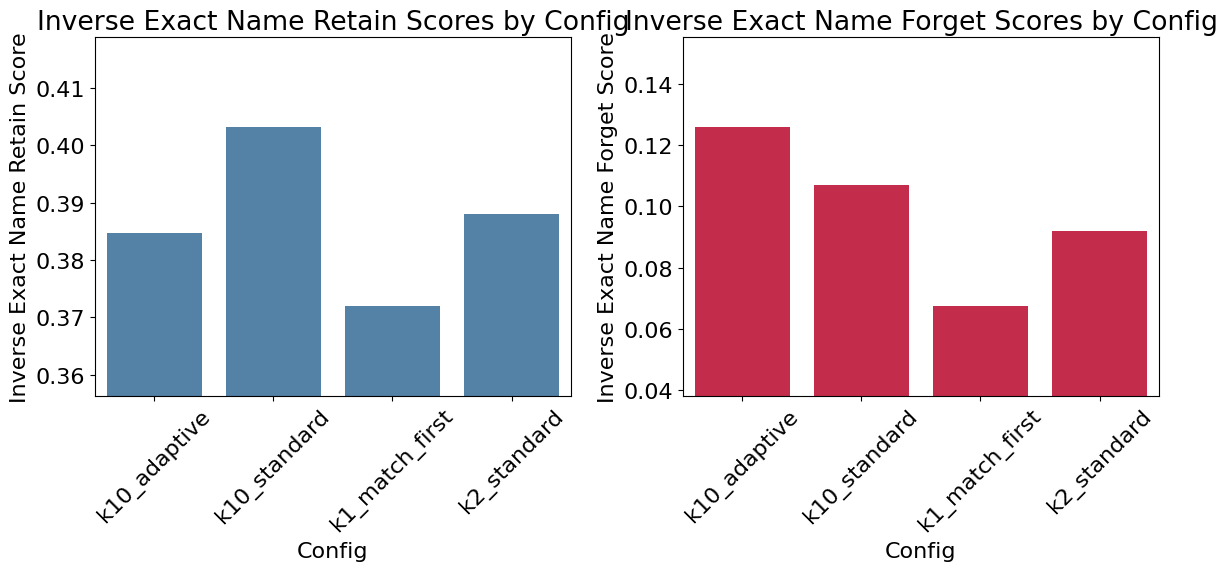

In [59]:
plot_retain_forget_scores(mean_df, 'inverse_scores_retain_exact', 'inverse_scores_forget_exact', title_prefix="Inverse Exact Name")
#plot_retain_forget_scores(mean_df, 'inverse_scores_retain_token_set_ratio', 'inverse_scores_forget_token_set_ratio', title_prefix="Inverse Token Set Ratio")

The inverse evaluation metrics show a clear advantage of the k1_match_first config, similarly to the targeted extraction attack and the one_hop pii leakage attack.

#### TOFU Metrics : Model Utility

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_metric(df, metric_col, title_prefix="Exact", figsize=(8, 6), adaptive_range=True, color='steelblue'):
    # Create figure with single subplot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[metric_col]].reset_index()
    
    # Create barplot
    sns.barplot(data=plot_df, x='config', y=metric_col, ax=ax, color=color)
    
    # Handle title formatting - special case for Model Utility
    if metric_col == 'Model Utility':
        title = f'{title_prefix} Model Utility by Config' if title_prefix else 'Model Utility by Config'
        ylabel = 'Model Utility'
    else:
        title = f'{title_prefix} {metric_col.replace("_", " ").title()} by Config'
        ylabel = f'{title_prefix} {metric_col.replace("_", " ").title()}'
    
    ax.set_title(title)
    ax.set_xlabel('Config')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    
    # Adapt y-axis range if requested
    if adaptive_range:
        metric_min, metric_max = plot_df[metric_col].min(), plot_df[metric_col].max()
        metric_padding = (metric_max - metric_min) * 0.5
        y_min = max(0, metric_min - metric_padding)  # Don't go below 0
        ax.set_ylim(y_min, metric_max + metric_padding)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        #'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
mean_df = calculate_model_utility(mean_df)

In [67]:
utility_columns = [
        #'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
mean_df[utility_columns]

,ROUGE Real Authors,Prob. Real Authors,Truth Ratio Real Authors,Prob. Real World,ROUGE Real World,Truth Ratio Real World
config,,,,,,
k10_adaptive,0.951,0.352719,0.363296,0.364711,0.914530,0.406187
k10_standard,0.957,0.379344,0.424858,0.373243,0.917379,0.420371
k1_match_first,0.939,0.346096,0.354978,0.360847,0.908832,0.399601
k2_standard,0.945,0.351156,0.362160,0.362850,0.911111,0.404758


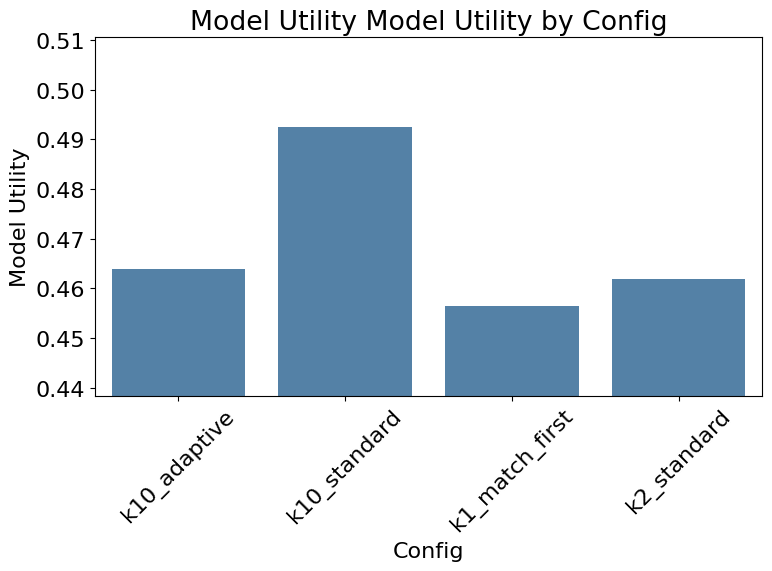

In [65]:
plot_single_metric(mean_df, 'Model Utility', title_prefix="Model Utility", color='steelblue')

We have very comparable model utiltiy across all 4 configurations.

#### TOFU Metrics : Fluency

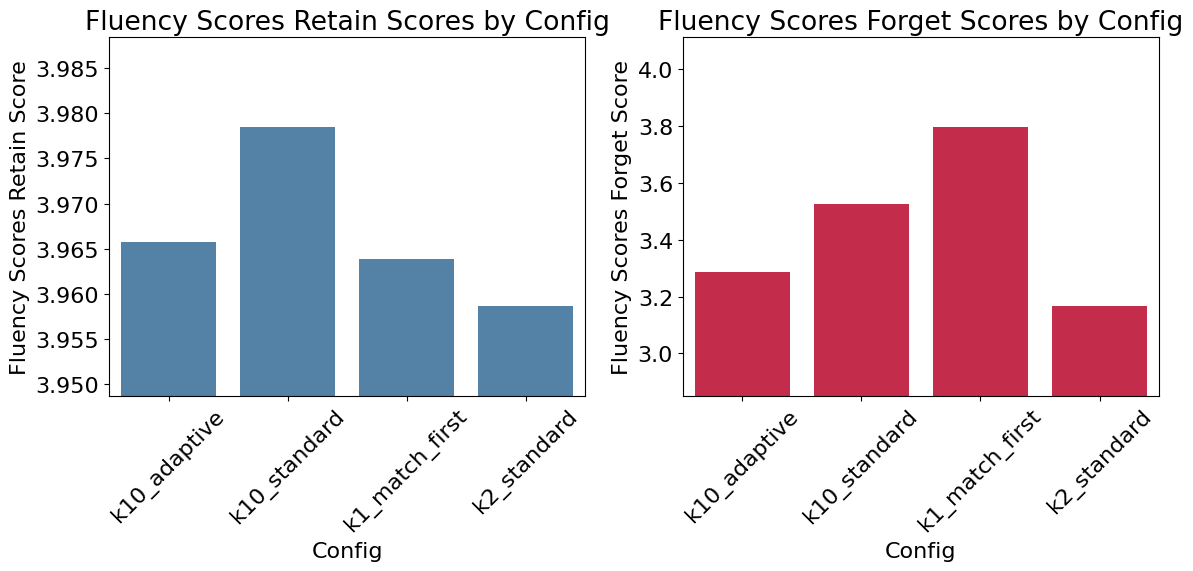

In [66]:
plot_retain_forget_scores(mean_df, 'Fluency Retain', 'Fluency Forget', title_prefix="Fluency Scores")
#plot_retain_forget_scores(mean_df, 'inverse_scores_retain_token_set_ratio', 'inverse_scores_forget_token_set_ratio', title_prefix="Inverse Token Set Ratio")

We have comparable fluency across all 4 configurations.

Compare 10 runs

In [7]:
import pandas as pd

main_exp_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/PIIAnalysis'
all_results = None


for run in range(1,11):
    for in_text in [False,True]:
        P = 1 if in_text else 1.2
        template_path = f'llama3.1-8b_E8_B16_C0.1_P_{P}_intext{in_text}_run{run}'
        results_path = 'eval_results/eval.csv'
        full_path = main_exp_path + '/' + template_path + '/' + results_path
        df = pd.read_csv(full_path)
        df['in_text'] = in_text
        df['run'] = run
        if run == 1 and P == 1.2:
            all_results = df
        else:
            all_results = pd.concat([all_results, df], ignore_index=True)      

grouped_results = all_results.groupby(['in_text']).mean(numeric_only=True).reset_index()

In [9]:
grouped_results.columns

Index(['in_text', 'para_scores_forget_exact',
       'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'para_scores_retain_exact',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'exact_retain_score', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'exact_forge

In [12]:
grouped_results[['inverse_scores_forget_exact','one_hop_scores_forget_pii','extraction_scores_forget_exact','extraction_scores_forget_exact','exact_forget_score','para_scores_forget_exact']]

,inverse_scores_forget_exact,one_hop_scores_forget_pii,extraction_scores_forget_exact,extraction_scores_forget_exact,exact_forget_score,para_scores_forget_exact
0,0.123,0.035849,0.000901,0.000901,0.002167,0.0061
1,0.045,0.037736,0.001001,0.001001,0.005000,0.0120
